# Bayesian Neural Network

In [14]:
import os
import sys
import matplotlib.pyplot as plt
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *
m = bi(platform='cpu')

jax.local_device_count 32


## Gaussian neural network
### Simulate data
We generate training and test data from a Bayesian neural network model. in order evaluate accuracy of the model.


jax.local_device_count 32


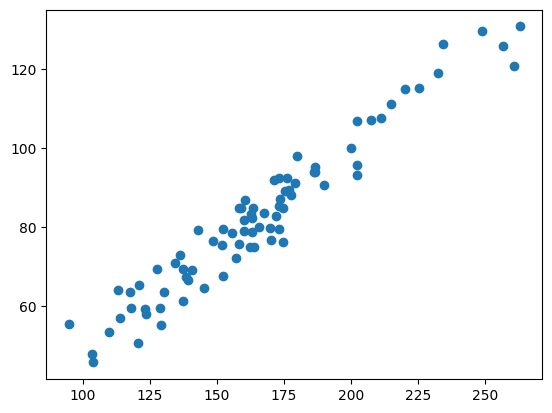

In [15]:

# setup platform------------------------------------------------
m = bi(platform='cpu')
alpha= 0.6
beta = 0.5
sigma= 5
x=m.dist.normal(160, 40,sample=True,shape=(100,))
lk=alpha+beta*x
y=bi.dist.normal(lk, sigma,sample=True,seed=2)
data=jnp.array([x,y]).T

def split_train_test(arr):
    # Get the length of the array
    n = arr.shape[0]
    
    # Calculate the split index (80% for training)
    train_idx = int(n * 0.8)
    
    # Generate a random permutation of indices
    key = jax.random.PRNGKey(0)  # You can use a fixed key for reproducibility
    permuted_indices = jax.random.permutation(key, n)
    
    # Split the permuted indices
    train_indices = permuted_indices[:train_idx]
    test_indices = permuted_indices[train_idx:]
    
    # Split the original array based on the indices
    train_set = arr[train_indices]
    test_set = arr[test_indices]
    
    return train_set, test_set

train, test = split_train_test(data)

dataTrain= dict(X=train[:,0].reshape((train[:,0].shape[0],1)),Y=train[:,1].reshape((train[:,0].shape[0],1)))

m.data_on_model=dataTrain

plt.scatter(dataTrain['X'], dataTrain['Y'])

In [57]:
def get_data(N=50, D_X=1, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    X = jnp.power(X[:, np.newaxis], jnp.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = jnp.dot(X, W) + 0.5 * jnp.power(0.5 + X[:, 1], 2.0) * jnp.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = jnp.linspace(-1.3, 1.3, N_test)
    X_test = jnp.power(X_test[:, np.newaxis], jnp.arange(D_X))

    return X, Y, X_test
X, Y, X_test = get_data(D_X = 2)


In [74]:
import numpy as np
D_H=50
D_Y=1
N, D_X = X.shape
## sample first layer (we put unit normal priors on all weights)
## First hidden layer: Transforms input to N × D_H (hidden units)
w1 = dist.normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H)),  name='w1',shape=(D_X,D_H), sample = True)
w1_1 = w1[:,:,0,0]
w1_2 = w1[0,0,:,:]
#z1 = activation(jnp.matmul(X, w1))  # <= first layer of activations#
### sample second layer
### Second hidden layer: Further transforms to N × D_H
##w2 = dist.normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, #D_H)),  name='w2',shape=(D_H,D_H))
##z2 = activation(jnp.matmul(z1, w2))  # <= second layer of activations#
## sample final layer of weights and neural network output
## Final layer (z3) computes linear combination of second hidden layer
#w3 = dist.normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y)),  name='w3',shape=(D_H,D_Y))
#z3 = jnp.matmul(z1, w3)  # <= output of the neural network
#print(z3)
## we put a prior on the observation noise
#prec_obs = dist.gamma(3.0, 1.0,name='prec_obs')
#sigma_obs = 1.0 / jnp.sqrt(prec_obs)#
#m.normal(z3, sigma_obs, obs=Y,shape=(N,D_Y),name='Y')

In [ ]:
linear= False
if linear:
    m.data_on_model=dataTrain
    X=dataTrain['X']
    Y=dataTrain['Y']
else:
    X=(X - jnp.mean(X))/jnp.std(X)
    m.data_on_model=dict(X=X, Y=Y) 


def activation(x):
    return jnp.tanh(x)
# ! This work with only one hidden layer
# ! however i can't make it run on a linear relationship
# define model ------------------------------------------------
def model(X, Y,  D_H=5, D_Y=1):  
    N, D_X = X.shape
    # sample first layer (we put unit normal priors on all weights)
    # First hidden layer: Transforms input to N × D_H (hidden units)
    w1 = dist.normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H)),  name='w1',shape=(D_X,D_H))
    z1 = activation(jnp.matmul(X, w1))  # <= first layer of activations

    # sample final layer of weights and neural network output
    # Final layer (z3) computes linear combination of second hidden layer
    w3 = dist.normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y)),  name='w3',shape=(D_H,D_Y))
    z3 = jnp.matmul(z1, w3)  # <= output of the neural network
    print(z3)
    # we put a prior on the observation noise
    prec_obs = dist.gamma(3.0, 1.0,name='prec_obs')
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)

    m.normal(z3, sigma_obs, obs=Y,shape=(N,D_Y),name='Y')



# Run sampler ------------------------------------------------
m.run(model, num_samples=500) 

[Text(0.5, 0, 'X'),
 Text(0, 0.5, 'Y'),
 Text(0.5, 1.0, 'Mean predictions with 90% CI')]

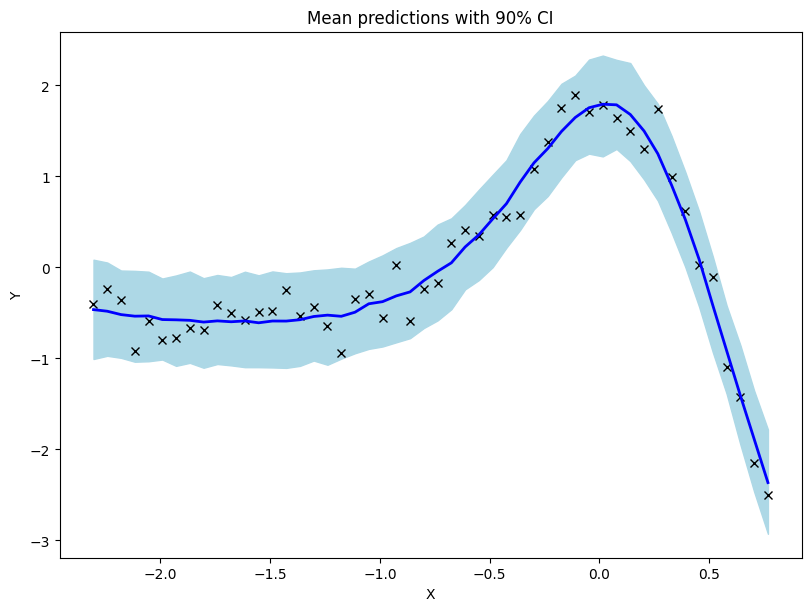

In [24]:
from numpyro import handlers
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace["Y"]["value"]


samples=m.sampler.get_samples()
vmap_args = (
    samples,
    random.split(rng_key_predict, 500 * 1),
)
predictions = vmap(
    lambda samples, rng_key: predict(model, rng_key, samples, X, 1)
)(*vmap_args)

predictions = predictions[..., 0]
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(X[:, 1], Y[:, 0], "kx")
# plot 90% confidence level of predictions
ax.fill_between(
    X[:, 1], percentiles[0, :], percentiles[1, :], color="lightblue"
)
# plot mean prediction
ax.plot(X[:, 1], mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")


# Testing neural network instead of lkj

In [161]:
import numpyro.distributions as dd
import pandas as pd
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *
import time as tm
# setup platform------------------------------------------------
m = bi(platform='cpu')

a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes
Mu = jnp.array([a, b])
cov_ab = sigma_a * sigma_b * rho
Sigma = jnp.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
jnp.array([1, 2, 3, 4]).reshape(2, 2).T
sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix
print("original Rho")
print(Rho)
# now matrix multiply to get covariance matrix
Sigma = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)

N_cafes = 20
seed = random.PRNGKey(5)  # used to replicate example
vary_effects = bi.dist.multivariatenormal(Mu, Sigma, shape=(N_cafes,), sample = True)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

seed = random.PRNGKey(22)
N_visits = 10
afternoon = jnp.tile(jnp.arange(2), N_visits * N_cafes // 2)
cafe_id = jnp.repeat(jnp.arange(N_cafes), N_visits)
mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes
wait = dist.normal(mu, sigma, sample = True)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
#d.to_csv('../resources/data/Sim data multivariatenormal.csv', index=False)

jax.local_device_count 32
original Rho
[[ 1.  -0.7]
 [-0.7  1. ]]


In [162]:
# import data ------------------------------------------------
m = bi()
m.df = d

m.data_on_model = dict(
    cafe = jnp.array(m.df.cafe.values, dtype=jnp.int32),
    wait = jnp.array(m.df.wait.values, dtype=jnp.float32),
    N_cafes = len(m.df.cafe.unique()),
    afternoon = jnp.array(m.df.afternoon.values, dtype=jnp.float32)
)

def model(cafe, wait, N_cafes, afternoon):
    a = dist.normal(5, 2,  name = 'a')
    b = dist.normal(-1, 0.5, name = 'b')
    sigma = dist.exponential( 1,  name = 'sigma')

    sigma_cafe = dist.exponential(1, shape=(2,),  name = 'sigma_cafe')    
    Rho = dist.lkj(2, 2, name = 'Rho')
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = dist.multivariatenormal(jnp.stack([a, b]), cov, shape = [N_cafes], name = 'a_b_cafe')    

    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    m.normal(mu, sigma, obs=wait)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.summary()

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:02<00:00, 481.02it/s, 15 steps of size 2.80e-01. acc. prob=0.90]


,mean,sd,hdi_5.5%,hdi_94.5%
"Rho[0, 0]",1.00,0.00,1.00,1.00
"Rho[0, 1]",-0.50,0.16,-0.73,-0.23
"Rho[1, 0]",-0.50,0.16,-0.73,-0.23
"Rho[1, 1]",1.00,0.00,1.00,1.00
a,3.51,0.21,3.15,3.82
"a_b_cafe[0, 0]",3.56,0.21,3.20,3.86
"a_b_cafe[0, 1]",-1.55,0.29,-1.93,-1.00
"a_b_cafe[1, 0]",5.34,0.22,5.03,5.72
"a_b_cafe[1, 1]",-1.39,0.31,-1.88,-0.90
"a_b_cafe[2, 0]",3.50,0.23,3.16,3.87


In [186]:
# import data ------------------------------------------------
m2 = bi()
m2.df = d

m2.data_on_model = dict(
    cafe = jnp.array(m.df.cafe.values, dtype=jnp.int32),
    wait = jnp.array(m.df.wait.values, dtype=jnp.float32),
    N_cafes = len(m.df.cafe.unique()),
    afternoon = jnp.array(m.df.afternoon.values, dtype=jnp.float32)
)

def model(cafe, wait, N_cafes, afternoon):
    # Global parameters for intercept and slope
    a = dist.normal(5, 2, name='a')
    b = dist.normal(-1, 0.5, name='b')
    sigma = dist.exponential(1, name='sigma')
    
    # --- Replace the covariance approach with a neural network ---
    # Bayesian neural network parameters for a two–layer MLP
    hidden_dim = 10  # you can change the hidden layer size
    # First layer weights/biases: note these are treated as latent parameters
    W1 = dist.normal(0, 1, shape=(N_cafes, hidden_dim), name='W1')
    # Second layer weights/biases
    W2 = dist.normal(0, 1, shape=(hidden_dim, 2), name='W2')

    # Create one-hot encoding for each cafe (each row is a one–hot vector)
    X = jnp.eye(N_cafes)  # shape: (N_cafes, N_cafes)    
    # First layer: project one-hot into a hidden representation
    hidden = jnp.tanh(jnp.dot(X, W1))  # shape: (N_cafes, hidden_dim)
    
    # Second layer: output two values per cafe (offsets for a and b)
    delta = jnp.dot(hidden, W2)        # shape: (N_cafes, 2)    
    
    # Neural network outputs serve as offsets to the global parameters.
    # This replaces the multivariate normal draw for a_cafe_b_cafe.
    a_cafe_b_cafe = numpyro.deterministic('a_cafe_b_cafe', jnp.stack([a, b]) + delta)  # shape: (N_cafes, 2)
    
    # Split the network output into cafe-specific intercept and slope
    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    
    m2.normal(mu, sigma, obs=wait)

# Run sampler ------------------------------------------------
m2.run(model)

# Diagnostic ------------------------------------------------
m2.summary()


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:03<00:00, 264.64it/s, 63 steps of size 5.06e-02. acc. prob=0.87]


,mean,sd,hdi_5.5%,hdi_94.5%
"W1[0, 0]",0.01,0.96,-1.48,1.43
"W1[0, 1]",-0.02,1.00,-1.64,1.48
"W1[0, 2]",-0.01,0.97,-1.56,1.61
"W1[0, 3]",-0.01,0.99,-1.46,1.60
"W1[0, 4]",-0.01,1.02,-1.56,1.52
...,...,...,...,...
"a_cafe_b_cafe[18, 1]",-0.05,0.30,-0.47,0.46
"a_cafe_b_cafe[19, 0]",2.79,0.22,2.44,3.13
"a_cafe_b_cafe[19, 1]",-0.51,0.31,-0.99,-0.02
b,-1.10,0.23,-1.38,-0.71


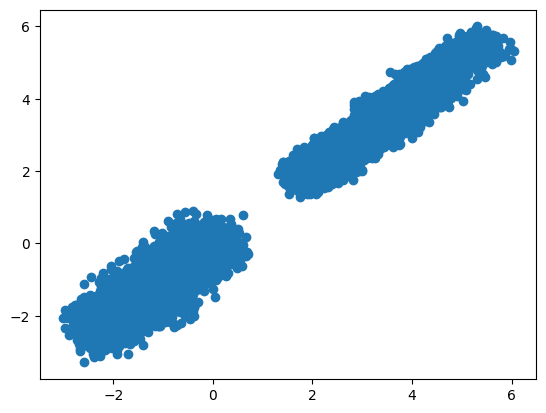

In [164]:
plt.scatter(m.posteriors['a_b_cafe'],m2.posteriors['a_cafe_b_cafe'])

In [171]:
import jax
import jax.numpy as jnp
def recover_Rho(posterior):
    # Assume a_cafe_b_cafe is a JAX array of shape (N_cafes, 2), where each row is [a_cafe, b_cafe]

    a_cafe_b_cafe =jnp.mean(posterior, axis=0) 
    N_cafes = a_cafe_b_cafe.shape[0]

    # 1. Compute sample covariance matrix
    mean_a_b_cafe = jnp.mean(a_cafe_b_cafe, axis=0)  # Mean of [a_cafe, b_cafe]

    centered_data = a_cafe_b_cafe - mean_a_b_cafe  # Center data by subtracting the mean

    cov_sample = jnp.dot(centered_data.T, centered_data) / (N_cafes - 1)  # Covariance matrix

    # 2. Extract sigma_cafe (standard deviations) from the diagonal of the covariance matrix
    sigma_cafe = jnp.sqrt(jnp.diagonal(cov_sample))  # Extract standard deviations (sqrt of variance)

    # 3. Compute Rho (correlation matrix)
    rho = cov_sample / (sigma_cafe[:, None] * sigma_cafe[None, :])  # Normalize covariance to obtain correlation matrix

    # Display the results
    print("Covariance matrix (Sigma):")
    print(cov_sample)
    print("\nStandard deviations (sigma_cafe):")
    print(sigma_cafe)
    print("\nCorrelation matrix (Rho):")
    print(rho)
    #return cov_sample, sigma_cafe, rho


print('\nm2 estimations covariance estimations (neural network)')
recover_Rho(m2.posteriors['a_cafe_b_cafe'])

print('\nm1 estimations covariance estimations (LKJ prior)')
print(jnp.mean(m.posteriors['Rho'], axis = 0))

print("\nSimulated values")
print("\nCorrelation matrix (Rho):")
print(Rho)
print("Covariance matrix (Sigma):")
print(Sigma)
print("\nStandard deviations (sigma_cafe):")
print(sigmas)




m2 estimations covariance estimations (neural network)
Covariance matrix (Sigma):
[[ 0.80802559 -0.36440995]
 [-0.36440995  0.44904903]]

Standard deviations (sigma_cafe):
[0.89890243 0.6701112 ]

Correlation matrix (Rho):
[[ 1.         -0.60496576]
 [-0.60496576  1.        ]]

m1 estimations covariance estimations (LKJ prior)
[[ 1.         -0.50319014]
 [-0.50319014  1.        ]]

Simulated values

Correlation matrix (Rho):
[[ 1.  -0.7]
 [-0.7  1. ]]
Covariance matrix (Sigma):
[[ 1.   -0.35]
 [-0.35  0.25]]

Standard deviations (sigma_cafe):
[1.  0.5]


In [181]:
a = dist.normal(5, 2, name='a', sample = True)
b = dist.normal(-1, 0.5, name='b', sample = True)
sigma = dist.exponential(1, name='sigma', sample = True)

# --- Replace the covariance approach with a neural network ---
# Bayesian neural network parameters for a two–layer MLP
hidden_dim = 10  # you can change the hidden layer size
# First layer weights/biases: note these are treated as latent parameters
W1 = dist.normal(0, 1, shape=(N_cafes, N_cafes, hidden_dim), name='W1', sample = True)
# Second layer weights/biases
W2 = dist.normal(0, 1, shape=(hidden_dim, 2), name='W2', sample = True)
# Create one-hot encoding for each cafe (each row is a one–hot vector)
X = jnp.eye(N_cafes)  # shape: (N_cafes, N_cafes)    
# First layer: project one-hot into a hidden representation
hidden = jnp.tanh(jnp.dot(X, W1))  # shape: (N_cafes, hidden_dim)
#
## Second layer: output two values per cafe (offsets for a and b)
#delta = jnp.dot(hidden, W2)        # shape: (N_cafes, 2)    
#
## Neural network outputs serve as offsets to the global parameters.
## This replaces the multivariate normal draw for a_cafe_b_cafe.
#a_cafe_b_cafe = numpyro.deterministic('a_cafe_b_cafe', jnp.stack([a, b]) + delta)  # shape: (N_cafes, 2)
#
## Split the network output into cafe-specific intercept and slope
#a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
#mu = a_cafe[cafe] + b_cafe[cafe] * afternoon

In [184]:
2*20^2*10 + 10^2

52

In [179]:
W1.shape

(20, 10)

In [180]:
X.shape

(20, 20)

In [182]:
hidden.shape

(20, 20, 10)

## Explanation

### Global parameters:
The model still defines overall intercept $a$ and slope $b$ as well as the observation noise $\sigma$.

### Neural network prior:
Instead of drawing each cafe’s $[a_{\text{cafe}}, b_{\text{cafe}}]$ from a multivariate normal with a structured covariance, we define a small MLP.

- The input $X$ is an identity matrix (one–hot encoding for each cafe).
- The first layer (with weights $W_1$ and biases $b_1$) maps the one–hot vectors into a hidden space using a $\tanh$ activation.
- The second layer (with weights $W_2$ and biases $b_2$) outputs a 2–dimensional vector for each cafe, which acts as an offset.

### Combining with global parameters:
Adding the network’s output $\delta$ to the global $[a, b]$ produces the cafe–specific parameters $a_{\text{cafe\_b\_cafe}}$. These are then used as before to form the linear predictor $\mu$.

This approach replaces the rigid covariance specification with a more flexible neural network prior that may capture complex variations across cafes.

## Cons
In this version ther is no equivalent of Rho returned.


In [110]:
# import data ------------------------------------------------
m3 = bi()
m3.data('../resources/data/Sim data multivariatenormal.csv', sep=',')

m3.data_on_model = dict(
    cafe = jnp.array(m.df.cafe.values, dtype=jnp.int32),
    wait = jnp.array(m.df.wait.values, dtype=jnp.float32),
    N_cafes = len(m.df.cafe.unique()),
    afternoon = jnp.array(m.df.afternoon.values, dtype=jnp.float32)
)

def model(cafe, wait, N_cafes, afternoon):
    # Global parameters for intercept and slope
    a = dist.normal(5, 2, name='a')
    b = dist.normal(-1, 0.5, name='b')
    sigma = dist.exponential(1, name='sigma')
    
    # --- Global correlation parameter (equivalent of Rho) ---
    Rho = dist.lkj(2, 2, name='Rho')  # 2x2 correlation matrix
    
    # --- Neural network for cafe-specific adjustments ---
    # The NN will output both an offset (delta) and log-scales (for the covariance) for each cafe.
    hidden_dim = 10  # size of hidden layer
    
    # First layer: from one-hot (N_cafes x N_cafes) to hidden representation
    W1 = dist.normal(0, 1, shape=(N_cafes, hidden_dim), name='W1')
    b1 = dist.normal(0, 1, shape=(hidden_dim,), name='b1')
    
    # Second layer: outputs 4 values per cafe:
    #   first two: offsets for intercept and slope,
    #   next two: log-scales for intercept and slope.
    W2 = dist.normal(0, 1, shape=(hidden_dim, 4), name='W2')
    b2 = dist.normal(0, 1, shape=(4,), name='b2')
    
    # One-hot encoding for each cafe (each row corresponds to one cafe)
    X = jnp.eye(N_cafes)  # shape: (N_cafes, N_cafes)
    
    # First layer activation
    hidden = jnp.tanh(jnp.dot(X, W1) + b1)  # shape: (N_cafes, hidden_dim)
    
    # Second layer outputs (raw NN outputs)
    nn_out = jnp.dot(hidden, W2) + b2  # shape: (N_cafes, 4)
    
    # Split the NN outputs:
    # - delta: offsets for a and b (shape: [N_cafes, 2])
    # - log_sigma_cafe: log-scales for a and b (shape: [N_cafes, 2])
    delta = nn_out[:, :2]
    log_sigma_cafe = nn_out[:, 2:]
    sigma_cafe = jnp.exp(log_sigma_cafe)  # ensures positive scales, shape: (N_cafes, 2)
    
    # Construct a covariance matrix for each cafe using the NN–derived scales and global Rho.
    # For each cafe, cov = outer(sigma_cafe[i], sigma_cafe[i]) * Rho
    cov_list = []
    for i in range(N_cafes):
        cov_i = jnp.outer(sigma_cafe[i], sigma_cafe[i]) * Rho
        cov_list.append(cov_i)
    cov = jnp.stack(cov_list, axis=0)  # shape: (N_cafes, 2, 2)
    
    # Mean for each cafe: global parameters plus NN–derived offsets
    mu_cafe = jnp.stack([a, b]) + delta  # shape: (N_cafes, 2)
    
    # Draw cafe–specific intercepts and slopes with the neural network–guided covariance.
    a_cafe_b_cafe = dist.multivariatenormal(mu_cafe, cov, shape=[N_cafes], name='a_b_cafe')
    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    
    # Likelihood for the observed wait times
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    m3.normal(mu, sigma, obs=wait)

# Run sampler ------------------------------------------------
m3.run(model)

# Diagnostic ------------------------------------------------
m3.summary()


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:28<00:00, 34.91it/s, 622 steps of size 1.18e-03. acc. prob=0.85]


,mean,sd,hdi_5.5%,hdi_94.5%
"Rho[0, 0]",1.00,0.00,1.00,1.00
"Rho[0, 1]",-0.02,0.40,-0.78,0.55
"Rho[1, 0]",-0.02,0.40,-0.78,0.55
"Rho[1, 1]",1.00,0.00,1.00,1.00
"W1[0, 0]",0.02,0.89,-1.50,1.33
...,...,...,...,...
b2[0],-0.37,0.98,-1.67,1.38
b2[1],0.11,0.87,-1.21,1.52
b2[2],-0.28,0.99,-1.61,1.54
b2[3],-0.58,0.82,-1.72,0.85


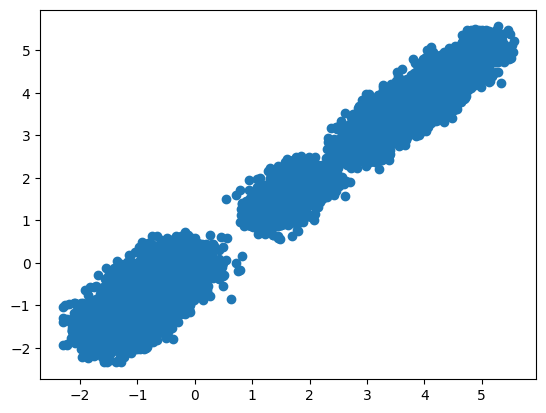

In [115]:
plt.scatter(m.posteriors['a_b_cafe'],m3.posteriors['a_b_cafe'])

In [113]:
import numpy as np

def is_positive_definite(matrix):
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False


print(is_positive_definite(jnp.mean(m.posteriors['Rho'], axis = 0))) 

print(is_positive_definite(jnp.mean(m3.posteriors['Rho'], axis = 0)))  # Output: True


True
True


## Explanation

### Global Correlation ($\rho$):  
The variable `Rho` is still drawn from an LKJ prior and represents the common 2×2 correlation matrix across cafes. This is analogous to the original model’s `Rho`.

### Neural Network Outputs:  
The NN now outputs 4 numbers per cafe:  

- The first two (`delta`) are additive offsets to the global $a$ and $b$.  
- The next two are used (after exponentiation) as scale parameters ($\sigma_{\text{cafe}}$) for each cafe.  

### Covariance Construction:  
For each cafe, the covariance matrix is constructed using the NN–derived scales and the global correlation matrix, via  

\[
\text{cov}_i = \text{outer}(\sigma_{\text{cafe}, i}, \sigma_{\text{cafe}, i}) \times \rho.
\]

This preserves an explicit role for $\rho$ while allowing the NN to provide flexible, cafe–specific scaling.  

This version therefore provides an equivalent of the original `Rho` while still using the neural network to inform the cafe–specific parameters.


In [ ]:
import numpy as np

# Suppose this is your given nonnegative eigenvector.
v = np.array([0.5, 0.5, 0.7071])  # example vector
v = v / np.linalg.norm(v)         # ensure it's normalized
n = len(v)

# Set the eigenvalue for v (largest eigenvalue)
lambda0 = 10.0

# Choose remaining eigenvalues (ensuring they are less than lambda0 for PF properties)
remaining_eigs = np.array([3.0, 2.0])  # arbitrary choices; length must be n-1

# First, create an orthonormal basis with v as the first vector.
# We'll generate a random matrix and replace its first column with v, then re-orthonormalize.
Q, _ = np.linalg.qr(np.random.randn(n, n))
Q[:, 0] = v
Q, _ = np.linalg.qr(Q)  # Re-orthonormalize to ensure Q is orthogonal

# Create the diagonal eigenvalue matrix.
L = np.diag(np.concatenate(([lambda0], remaining_eigs)))

# Reconstruct the matrix.
A = Q @ L @ Q.T

# Verify that v is (approximately) an eigenvector with eigenvalue lambda0.
eigenvalues, eigenvectors = np.linalg.eig(A)
# Find the eigenvalue closest to lambda0.
idx = np.argmin(np.abs(eigenvalues - lambda0))
print("Computed eigenvalue:", eigenvalues[idx])
print("Eigenvector corresponding to lambda0:", eigenvectors[:, idx])
print("Original vector v:", v)

np.fill_diagonal(A, 0)
G = nx.from_numpy_array(A)
centrality = nx.eigenvector_centrality_numpy(G)
for node, value in centrality.items():
    print(f"Node {node}: {value}")

Computed eigenvalue: 10.000000000000004
Eigenvector corresponding to lambda0: [0.5000024  0.5000024  0.70710339]
Original vector v: [0.5000024  0.5000024  0.70710339]
